# Tarea I: DNNs
**Fecha:** 21 de septiembre de 2025

## Resumen

El objetivo es revisar los fundamentos de la diferenciación automática y el uso de PyTorch. 

TODO: Formatee las soluciones en LaTeX y prepare un único PDF con todo el desarrollo y el archivo `.ipynb`. No resolver los ejercicios directamente en este notebook; deje las celdas de código y las áreas necesarias para completar las soluciones en el PDF final.

## Problema 1

Sean $x$ y $\mathbf{1} := (1,1,\ldots,1)$ vectores en $\mathbb{R}^n$. Considere la función de Rosenbrock:

$$
f(x) = \sum_{i=1}^{n-1} \left( 100\, (x_{i+1} - x_i^2)^2 + (x_i - 1)^2 \right), \qquad (1)
$$

Calcule $\nabla f(\mathbf{1})$ usando diferenciación automática en sentido reverso (cálculo a mano), para $n = 5$.



# Solución problema 1: Rosenbrock y diferenciación automática
A continuación se muestran los pasos completos para el problema 1, incluyendo el diseño del grafo computacional, el cálculo de derivadas simbólicas y el barrido hacia atrás.

## 1. Grafo computacional de la función de Rosenbrock para n=5
![](images/grafo.jpeg)

## 2. Cálculo de derivadas simbólicas y evaluación en el punto $x_i=1$
![](images/derivadas_simbolicas.jpeg)

## 3. Barrido hacia atrás (reverse mode), inicializando $g_i=1$
![](images/barrido.jpeg)



## Problema 2

Escriba un script en Python usando PyTorch para calcular el valor propio de mayor módulo y su correspondiente vector propio de una matriz simétrica $A \in \mathbb{R}^{n\times n}$. Utilice el método de la potencia (Power method), tal y como se describe en Golub \& Van Loan (sección 8.2.1).

Pruebe su programa con la siguiente matriz de prueba:

$$
A = \begin{pmatrix}
-1.6407 & 1.0814 & 1.2014 & 1.1539 \",
1.0814 & 4.1573 & 7.4035 & -1.0463 \",
1.2014 & 7.4035 & 2.7890 & -1.5737 \",
1.1539 & -1.0463 & -1.5737 & 8.6944
\end{pmatrix}
$$


In [1]:
import torch

In [ ]:
def power_method(dim, iter, matrix):
    q = torch.rand(dim)
    q = q / torch.norm(q, p=2)
    
    for k in range(iter):
        q_prev = q.clone()
        z = matrix.matmul(q_prev) 
        q = z / torch.norm(z, p=2)
        λ = torch.dot(q, matrix.matmul(q))
    return λ, q
        
    
    

In [52]:
A = torch.tensor([
    [-1.6407,  1.0814,  1.2014,  1.1539],
    [ 1.0814,  4.1573,  7.4035, -1.0463],
    [ 1.2014,  7.4035,  2.7890, -1.5737],
    [ 1.1539, -1.0463, -1.5737,  8.6944]
], dtype=torch.float32)

λ, q = power_method(A.shape[0], 100, A)
print("Valor propio de mayor módulo:", λ.item())
print("Vector propio correspondiente:", q)

Valor propio de mayor módulo: 12.000048637390137
Vector propio correspondiente: tensor([ 0.0645,  0.6416,  0.6041, -0.4682])


## Problema 3

Minimizar numéricamente la función (1) para $n = 10$ usando el método de Newton con PyTorch. Incluya una gráfica que muestre cómo decrece el error o la norma del gradiente a lo largo de las iteraciones.

In [127]:

import matplotlib.pyplot as plt

def newton_method(func, dim, iter):
    x = torch.rand(dim, requires_grad=True)
    grad_norms = []
    values = []
    
    for k in range(iter):
        x_prev = x.clone()
        fx = func(x)
        grad = torch.autograd.grad(fx, x, create_graph=True)[0]
        hess = []
        for g in grad:
            row = torch.autograd.grad(g, x, retain_graph=True)[0]
            hess.append(row)
        hess = torch.stack(hess)
        delta = torch.inverse(hess) @ grad
        x = x_prev - delta
        x = x.detach().requires_grad_()
        
        grad_norms.append(torch.norm(grad).item())
        values.append(fx.item())
    
    # Plot gradient norm decay
    plt.figure(figsize=(6,4))
    plt.plot(range(iter), grad_norms, marker='o')
    plt.xlabel('Iteración')
    plt.ylabel('Norma del gradiente')
    plt.title('Decaimiento de la norma del gradiente (Newton)')
    plt.grid(True)
    plt.show()
    
    return x, func(x)

def rosenbrock(x):
    return sum(100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2 for i in range(len(x)-1))


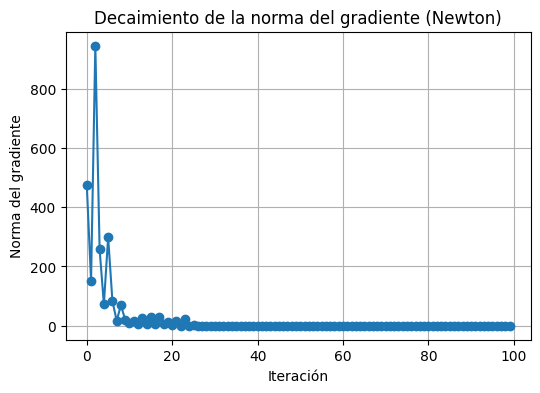

Punto encontrado: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
Valor de la función en el mínimo: 0.0


In [137]:
n = 10
iter = 100

x, value = newton_method(rosenbrock, n, iter)
print("Punto encontrado:", x)
print("Valor de la función en el mínimo:", value.item())

## Problema 4

Minimizar numéricamente la función (1) para $n = 10$ usando el método BFGS implementado con PyTorch (por ejemplo, a través de la interfaz de optimización adecuada).
Grafique cómo disminuye el error (o la norma del gradiente) a medida que avanza el algoritmo.



In [ ]:
def bfgs(fun, dim, alpha, Iters):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    w = torch.rand(dim, requires_grad=True, device=device)
    h = torch.eye(dim, device=device)

    grad_norms = []

    fw = fun(w)
    fw.backward()
    grad_prev = w.grad.clone()

    for i in range(Iters):
        with torch.no_grad():
            pk = -h @ grad_prev
            w_prev = w.clone()
            w += alpha * pk

        w.grad.zero_()
        fw = fun(w)
        fw.backward()
        grad_new = w.grad.clone()

        sk = w - w_prev
        yk = grad_new - grad_prev

        rho = 1.0 / (yk @ sk)
        I = torch.eye(dim, device=device)
        h = (I - rho * sk.unsqueeze(1) @ yk.unsqueeze(0)) @ h @ (I - rho * yk.unsqueeze(1) @ sk.unsqueeze(0)) + rho * sk.unsqueeze(1) @ sk.unsqueeze(0)

        grad_prev = grad_new.clone()
        grad_norms.append(grad_new.norm().item())

        print(f'Iter {i+1}/{Iters}, f(w)={fw.item()}, ||grad||={grad_new.norm().item()}')

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, Iters + 1), grad_norms, marker='o', linestyle='-', color='navy')
    plt.xlabel('Iteración', fontsize=12)
    plt.ylabel('Norma del gradiente', fontsize=12)
    plt.title('Decaimiento de la norma del gradiente (BFGS)', fontsize=14)
    plt.yscale('log')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    return w, fw

Iter 1/3000, f(w)=124.27421569824219, ||grad||=244.9038543701172
Iter 2/3000, f(w)=129.33868408203125, ||grad||=306.3021240234375
Iter 3/3000, f(w)=160.74696350097656, ||grad||=350.37652587890625
Iter 4/3000, f(w)=157.84259033203125, ||grad||=366.40118408203125
Iter 5/3000, f(w)=153.62672424316406, ||grad||=344.6415710449219
Iter 6/3000, f(w)=150.1678924560547, ||grad||=350.8798522949219
Iter 7/3000, f(w)=145.73997497558594, ||grad||=343.62335205078125
Iter 8/3000, f(w)=191.03579711914062, ||grad||=465.8402404785156
Iter 9/3000, f(w)=173.01280212402344, ||grad||=404.1518249511719
Iter 10/3000, f(w)=116.2259750366211, ||grad||=314.4903564453125
Iter 11/3000, f(w)=112.72748565673828, ||grad||=307.08551025390625
Iter 12/3000, f(w)=111.81499481201172, ||grad||=304.8804016113281
Iter 13/3000, f(w)=111.12223815917969, ||grad||=303.3611755371094
Iter 14/3000, f(w)=110.4167251586914, ||grad||=301.8268737792969
Iter 15/3000, f(w)=109.70940399169922, ||grad||=300.3099060058594
Iter 16/3000, f(w)

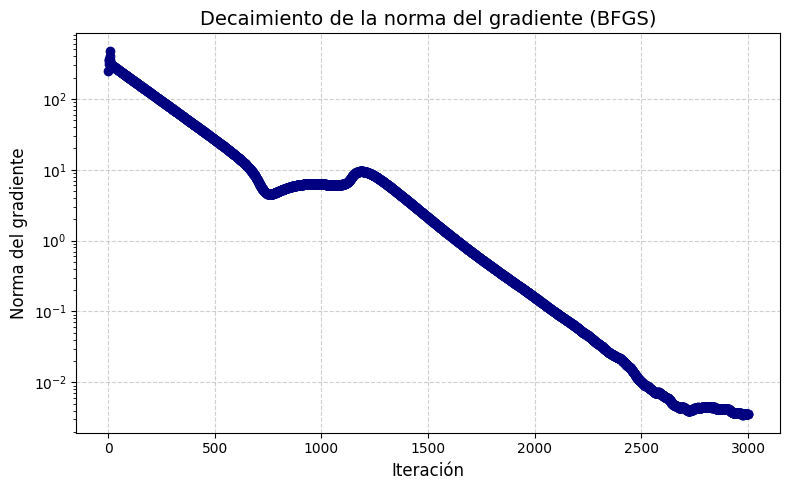

Punto encontrado: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 0.9997,
        0.9994], device='cuda:0', requires_grad=True)
Valor de la función en el mínimo: 1.2565000417907868e-07


In [141]:
n = 10
iter = 3000
alpha = 0.005

x, value = bfgs(rosenbrock, n, alpha, iter)
print("Punto encontrado:", x)
print("Valor de la función en el mínimo:", value.item())

## Problema 5

Minimizar numéricamente la función (1) para $n = 10$ usando el optimizador Adam en PyTorch.
Emplee PyTorch para implementar el algoritmo y grafique cómo disminuye el error (o la norma del gradiente) a lo largo de las iteraciones.

In [149]:
def adam(func, dim, alpha, b1, b2, e, iter):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x = torch.rand(dim, requires_grad=True, device=device)
    m = torch.zeros_like(x, device=device)
    v = torch.zeros_like(x, device=device)
    grad_norms = []

    for t in range(iter):
        fx = func(x)
        if x.grad is not None:
            x.grad.zero_()
        fx.backward()
        grad = x.grad.clone()

        m = b1 * m + (1 - b1) * grad
        v = b2 * v + (1 - b2) * grad ** 2
        m_hat = m / (1 - b1 ** (t + 1))
        v_hat = v / (1 - b2 ** (t + 1))

        with torch.no_grad():
            x -= alpha * (m_hat / (torch.sqrt(v_hat) + e))

        grad_norms.append(grad.norm().item())
        print(f'Iter {t+1}/{iter}, f(x)={fx.item()}, ||grad||={grad.norm().item()}')

    plt.figure(figsize=(6,4))
    plt.plot(range(1, iter+1), grad_norms, marker='o')
    plt.xlabel('Iteración')
    plt.ylabel('Norma del gradiente')
    plt.yscale('log')
    plt.title('Decaimiento de la norma del gradiente (Adam)')
    plt.grid(True)
    plt.show()

    return x, func(x)


Iter 1/800, f(x)=122.30621337890625, ||grad||=212.99465942382812
Iter 2/800, f(x)=100.78836822509766, ||grad||=146.0206756591797
Iter 3/800, f(x)=87.9985122680664, ||grad||=100.62966918945312
Iter 4/800, f(x)=80.70611572265625, ||grad||=73.70841979980469
Iter 5/800, f(x)=77.1572494506836, ||grad||=68.29122924804688
Iter 6/800, f(x)=75.2304458618164, ||grad||=76.26632690429688
Iter 7/800, f(x)=72.92698669433594, ||grad||=83.116943359375
Iter 8/800, f(x)=69.33759307861328, ||grad||=82.12176513671875
Iter 9/800, f(x)=64.82865142822266, ||grad||=73.63388061523438
Iter 10/800, f(x)=60.316001892089844, ||grad||=61.40190887451172
Iter 11/800, f(x)=56.520965576171875, ||grad||=50.89717483520508
Iter 12/800, f(x)=53.553043365478516, ||grad||=46.50403594970703
Iter 13/800, f(x)=51.11981964111328, ||grad||=47.85422134399414
Iter 14/800, f(x)=48.92568588256836, ||grad||=51.8202018737793
Iter 15/800, f(x)=46.72700119018555, ||grad||=55.616214752197266
Iter 16/800, f(x)=44.33674621582031, ||grad||=5

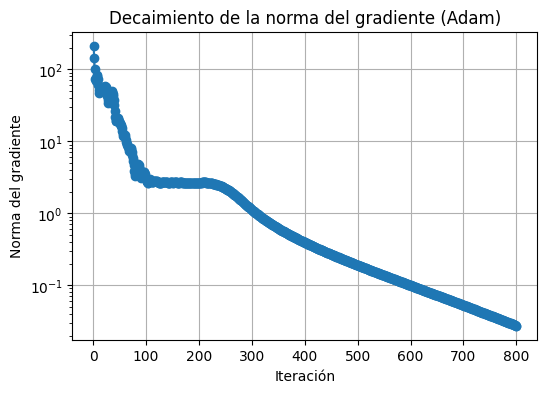

In [157]:
alpha = 0.05
b1 = 0.9
b2 = 0.999
e = 1e-8
iter = 800
n = 10

x, val = adam(rosenbrock, 10, alpha, b1, b2, e, iter)

In [160]:
!jupyter nbconvert --to html Tarea1.ipynb
!jupyter nbconvert --to pdf Tarea1.ipynb

[NbConvertApp] Converting notebook Tarea1.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 754745 bytes to Tarea1.html
[NbConvertApp] Converting notebook Tarea1.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'Tarea1.ipynb'
Traceback (most recent call last):
  File "C:\Users\evolu\AppData\Roaming\Python\Python312\site-packages\nbconvert\nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\evolu\AppData\Roaming\Python\Python312\site-packages\nbconvert\exporters\templateexporter.py", line 390, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\evolu\AppData\Roaming\Python\Python312\site-packages\nbconvert\exporters\exporter.py", line 201, in from_filename
    return self